In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('heart_disease.csv')
df.head()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
## We must drop education column 
df.drop(['education'],axis=1,inplace=True)
df.head()

,sex,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
# Find NAN
#NAN_df = df[df.isna().any(axis=1)]
#display(nan_df)
# drop NAN
df = df.dropna(axis=0)
df.isnull().sum()


sex                0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

# Train/Test/Split

In [5]:
X = df.drop('TenYearCHD',axis=1).values
y = df['TenYearCHD'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=13)

In [6]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [7]:
X_train.shape # we have 14 features.

torch.Size([3000, 14])

# Create a model class


In [8]:
class Model(nn.Module):
    def __init__(self,input_layer=14,h1=128,h2=64,h3=32,h4=16,h5=8,output_layer=2):
        super().__init__()
        self.fc1 = nn.Linear(input_layer,h1)      #input layers
        self.fc2 = nn.Linear(h1, h2)              #hidden layers
        self.fc3 = nn.Linear(h2, h3)              #hidden layers
        self.fc4 = nn.Linear(h3, h4)              #hidden layers
        self.fc5 = nn.Linear(h4, h5)              #hidden layers
        self.out = nn.Linear(h5, output_layer)    #output layers
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.out(x)
        return x

In [9]:
torch.manual_seed(42)
model = Model()
model

Model(
  (fc1): Linear(in_features=14, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=2, bias=True)
)

In [10]:
#loss and optimizations
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [11]:
#Train 
epochs = 100
losses = []

for i in range(epochs):
    i+=1
    loss = criterion(model.forward(X_train), y_train)
    losses.append(loss)
    
    
    if i%10 == 0:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 10  loss: 0.65212619
epoch: 20  loss: 0.49752092
epoch: 30  loss: 0.44410676
epoch: 40  loss: 0.42755091
epoch: 50  loss: 0.42508802
epoch: 60  loss: 0.42426425
epoch: 70  loss: 0.42303914
epoch: 80  loss: 0.42213219
epoch: 90  loss: 0.42126563
epoch: 100  loss: 0.42046964


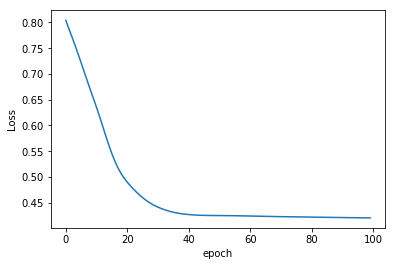

In [12]:
### plot
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

In [20]:
### Predictions
correct = 0
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.forward(data)
        print(f'{i+1:2}. {str(y_val):38}  {y_test[i]}')
        if y_val.argmax().item() == y_test[i]:
            correct += 1

print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')

 1. tensor([2.7739, 1.0503])                0
 2. tensor([3.0431, 1.1390])                0
 3. tensor([3.3787, 1.3867])                0
 4. tensor([2.9444, 1.0887])                0
 5. tensor([2.0394, 0.6700])                1
 6. tensor([2.6479, 1.0217])                0
 7. tensor([2.6683, 1.0635])                1
 8. tensor([2.6232, 0.9696])                0
 9. tensor([2.3178, 0.8110])                0
10. tensor([3.1304, 1.1429])                0
11. tensor([1.7518, 0.5528])                0
12. tensor([2.9233, 1.1271])                0
13. tensor([2.3505, 0.8402])                0
14. tensor([2.5231, 0.9345])                0
15. tensor([2.4965, 0.8927])                0
16. tensor([2.7768, 1.0181])                0
17. tensor([2.8434, 1.0691])                0
18. tensor([2.7159, 1.0272])                0
19. tensor([2.1618, 0.7485])                0
20. tensor([2.6099, 0.9315])                0
21. tensor([3.2297, 1.2528])                0
22. tensor([3.6906, 1.5010])      

227. tensor([2.9632, 1.1481])                0
228. tensor([2.7430, 1.0024])                0
229. tensor([2.9587, 1.1020])                0
230. tensor([3.1161, 1.2006])                1
231. tensor([2.2415, 0.7939])                0
232. tensor([3.6843, 1.4380])                0
233. tensor([2.1646, 0.7903])                0
234. tensor([3.5767, 1.4449])                0
235. tensor([2.6231, 0.9686])                0
236. tensor([2.4702, 0.9688])                0
237. tensor([1.8478, 0.6227])                0
238. tensor([3.1755, 1.2758])                1
239. tensor([2.9411, 1.1433])                0
240. tensor([1.5519, 0.5265])                0
241. tensor([2.3538, 0.8309])                0
242. tensor([3.2478, 1.2210])                1
243. tensor([0.7961, 1.0817])                0
244. tensor([2.7096, 1.0096])                0
245. tensor([2.2406, 0.8400])                1
246. tensor([2.9397, 1.1096])                0
247. tensor([2.5853, 0.9459])                0
248. tensor([

450. tensor([4.0186, 1.7073])                1
451. tensor([2.0148, 0.7130])                0
452. tensor([3.1900, 1.2285])                0
453. tensor([2.4149, 0.9315])                0
454. tensor([3.6619, 1.4860])                0
455. tensor([2.1319, 0.9570])                0
456. tensor([2.1971, 0.7540])                0
457. tensor([2.4400, 0.8616])                0
458. tensor([2.8663, 1.1518])                0
459. tensor([2.7361, 1.0660])                0
460. tensor([1.9498, 0.7050])                0
461. tensor([2.5786, 0.9226])                1
462. tensor([2.5860, 0.9348])                0
463. tensor([2.5020, 0.8839])                0
464. tensor([2.7675, 1.0672])                1
465. tensor([2.6649, 0.9717])                0
466. tensor([3.0565, 1.1992])                0
467. tensor([2.9415, 1.0520])                0
468. tensor([2.4642, 0.8948])                0
469. tensor([2.4725, 0.9104])                0
470. tensor([2.9805, 1.1052])                0
471. tensor([

676. tensor([2.6168, 0.9986])                1
677. tensor([2.6437, 1.0029])                0
678. tensor([2.7639, 1.0077])                0
679. tensor([3.3274, 1.3524])                0
680. tensor([2.8139, 1.0557])                0
681. tensor([2.8119, 1.0564])                0
682. tensor([2.0502, 0.6880])                0
683. tensor([2.8069, 1.0606])                0
684. tensor([2.2219, 0.7573])                0
685. tensor([3.1191, 1.2348])                0
686. tensor([2.2879, 0.8044])                0
687. tensor([2.3581, 0.8095])                0
688. tensor([2.5775, 1.0003])                0
689. tensor([2.8297, 1.0164])                0
690. tensor([3.2124, 1.2694])                0
691. tensor([2.3610, 0.8959])                0
692. tensor([2.6762, 0.9482])                0
693. tensor([2.9884, 1.1141])                0
694. tensor([2.0563, 0.6987])                0
695. tensor([3.4766, 1.3320])                1
696. tensor([2.7326, 1.0726])                1
697. tensor([

1 : Heart Attack Risk , 0 : No Heart Attack Risk


In [21]:
#Save the Model
torch.save(model.state_dict(), 'Heart_Disease.pt')